In [49]:
%pip install -q -U langchain-google-genai langchain_core langgraph

In [50]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for msg in messages:
    msg.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


In [51]:
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

In [52]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=GEMINI_API_KEY)

result = llm.invoke(messages)
print(type(result))
result

<class 'langchain_core.messages.ai.AIMessage'>


AIMessage(content='That\'s a great question! Orcas, also known as killer whales, are fascinating creatures.  The best place in the US to see them depends on what you\'re looking for in your experience.  Here are a few options:\n\n**For the most consistent sightings:**\n\n* **San Juan Islands, Washington:** This archipelago is known as the "Orca Capital of the World" for good reason.  The resident pods of orcas spend a lot of time in the waters around the islands, especially during the summer months. You can take a whale watching tour or even kayak alongside them. \n\n**For a unique experience:**\n\n* **Alaska:**  Alaska\'s waters are home to both resident and transient orcas.  You can see them from land, on a boat tour, or even from a seaplane.  You might even spot them hunting seals or salmon.  \n\n**For a combination of orcas and other marine life:**\n\n* **California:**  While orcas are not as common in California as they are in the Pacific Northwest, you can still spot them off the

In [53]:
result.response_metadata

{'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
 'finish_reason': 'STOP',
 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT',
   'probability': 'NEGLIGIBLE',
   'blocked': False},
  {'category': 'HARM_CATEGORY_HATE_SPEECH',
   'probability': 'NEGLIGIBLE',
   'blocked': False},
  {'category': 'HARM_CATEGORY_HARASSMENT',
   'probability': 'NEGLIGIBLE',
   'blocked': False},
  {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT',
   'probability': 'NEGLIGIBLE',
   'blocked': False}]}

In [54]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first parameter that is int
        b: second parameter that is int
    """
    return a * b

llm_with_tools: ChatGoogleGenerativeAI = llm.bind_tools([multiply])

In [55]:
response = llm_with_tools.invoke([HumanMessage(content="Multiply 10 by 10", name="Sarfaraz")])
response

AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 10.0, "b": 10.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-00ff9c68-6a05-47a7-b312-978ff5974e98-0', tool_calls=[{'name': 'multiply', 'args': {'a': 10.0, 'b': 10.0}, 'id': '4b1639a8-7118-4d70-bafd-e16818cd33d8', 'type': 'tool_call'}], usage_metadata={'input_tokens': 63, 'output_tokens': 20, 'total_tokens': 83, 'input_token_details': {'cache_read': 0}})

In [56]:
response.additional_kwargs

{'function_call': {'name': 'multiply', 'arguments': '{"a": 10.0, "b": 10.0}'}}

#Using messages as state

In [57]:
from typing import TypedDict, List
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
  messages: List[AnyMessage]

###When the graph runs then each node will override previous state. If we want to maintain the conversation history then we can use add_messages reducer. This reducer can be used for many tasks like adding, updating messages etc in a state.

In [ ]:
from typing import Annotated, List
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]

In [59]:
initial_messages = [
    HumanMessage(content="What is a GPU in simple words ?", name="Sarfaraz"),
    AIMessage(content="A GPU (Graphics Processing Unit) is a computer chip designed \
                         to handle graphics and visual tasks quickly. It’s especially useful \
                         in gaming, video editing, and data processing, where it speeds up complex tasks.")
]

new_message = HumanMessage(content="Teach me langgraph basics ?", name="Sarfaraz")

res = add_messages(initial_messages, new_message)
res

[HumanMessage(content='What is a GPU in simple words ?', additional_kwargs={}, response_metadata={}, name='Sarfaraz', id='2e6dc327-4a3d-4a4c-a2c8-633bb9c8c8f8'),
 AIMessage(content='A GPU (Graphics Processing Unit) is a computer chip designed                          to handle graphics and visual tasks quickly. It’s especially useful                          in gaming, video editing, and data processing, where it speeds up complex tasks.', additional_kwargs={}, response_metadata={}, id='25107186-0d6c-402e-a0f9-ea793b851ac6'),
 HumanMessage(content='Teach me langgraph basics ?', additional_kwargs={}, response_metadata={}, name='Sarfaraz', id='42a63368-a0e2-4a8e-b2fa-96ab2f4704b8')]

#Now using MessagesState in graph which is the same as messages: Annotated[List[AnyMessage, add_messages]]

In [60]:
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.state import CompiledStateGraph
from IPython.display import display, Image

class ConversationState(MessagesState):
  pass

def tool_calling_llm(state: ConversationState):
  return { "messages": [llm_with_tools.invoke(state["messages"])] }

builder = StateGraph(state_schema=ConversationState)

builder.add_node("Tool Calling LLM", tool_calling_llm)

builder.add_edge(START, "Tool Calling LLM")
builder.add_edge("Tool Calling LLM", END)

graph = builder.compile()

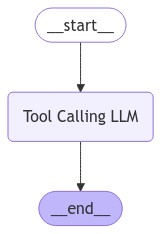

In [61]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [65]:
graph.invoke({"messages": HumanMessage(content="Hello")})

{'messages': [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='694ff173-7f5d-47fe-a40f-15a7971a0c15'),
  AIMessage(content='Hello! How can I help you today? 😊 \n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-73c897b9-751c-4d06-9516-66f992e34b8e-0', usage_metadata={'input_tokens': 56, 'output_tokens': 10, 'total_tokens': 66, 'input_token_details': {'cache_read': 0}})]}

In [66]:
graph.invoke({"messages": HumanMessage(content="Why is the sky blue ?")})

{'messages': [HumanMessage(content='Why is the sky blue ?', additional_kwargs={}, response_metadata={}, id='5c8f498f-31c3-44b9-8267-afd492f19552'),
  AIMessage(content="The sky appears blue due to a phenomenon called **Rayleigh scattering**. \n\nHere's a simplified explanation:\n\n* **Sunlight is made up of all colors of the rainbow.**\n* **When sunlight enters the Earth's atmosphere, it collides with tiny particles like air molecules.**\n* **Blue light, with its shorter wavelengths, is scattered more effectively than other colors by these particles.**\n* **This scattered blue light reaches our eyes from all directions, making the sky appear blue.**\n\nLet me know if you'd like to explore this further! \n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH'

In [70]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 5 by 3")})

for msg in messages['messages']:
  msg.pretty_print()

================================ Human Message =================================

Multiply 5 by 3
================================== Ai Message ==================================
Tool Calls:
  multiply (e63d57fd-aaca-4efe-b2c8-415c06a97a86)
 Call ID: e63d57fd-aaca-4efe-b2c8-415c06a97a86
  Args:
    b: 3.0
    a: 5.0
